<a href="https://colab.research.google.com/github/NickPavlovskii/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Рассмотрим простой пример

In [ ]:
from keras.layers import Conv2DTranspose, BatchNormalization, Input, GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU

# функция для создания слоев дискриминатора 
def build_discriminator(start_filters, spatial_dim, filter_size):
    
    # функция создания блока CNN block для уменьшения размера изображения
    def add_discriminator_block(x, filters, filter_size):
      x = Conv2DTranspose(filters, filter_size, padding='same')(x)
      x = BatchNormalization()(x)
      x = Conv2DTranspose(filters, filter_size, padding='same', strides=2)(x)
      x = BatchNormalization()(x)
      x = LeakyReLU(0.3)(x)
      return x
    
    # ввод - это изображение с размерами spatial_dim x spatial_dim и 3 каналами
    inp = Input(shape=(spatial_dim, spatial_dim, 3))

    # строим дискриминатор для уменьшения изображения в 4 раза
    x = add_discriminator_block(inp, start_filters, filter_size)
    x = add_discriminator_block(x, start_filters * 2, filter_size)
    x = add_discriminator_block(x, start_filters * 4, filter_size)
    x = add_discriminator_block(x, start_filters * 8, filter_size)
    
    # усреднение и возврат бинарного вывода
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs=inp, outputs=x)

В процессе обучения вы будете использовать алгоритм для настройки параметров модели. Цель состоит в том, чтобы функция потерьએ была минимальна, чтобы модель изучила распределение вероятностей выходных данных с учетом входных данных. После этапа обучения вы можете использовать модель для классификации нового рукописного цифрового изображения путем оценки наиболее вероятной цифры, которой соответствует ввод, как показано на рисунке ниже:

In [ ]:
from keras.layers import  Conv2DTranspose, Reshape

def build_generator(start_filters, filter_size, latent_dim):
  
  # функция для создания блока CNN, увеличивающего размеры изображения
  def add_generator_block(x, filters, filter_size):
      x = Conv2DTranspose(filters, filter_size, strides=2, padding='same')(x)
      x = BatchNormalization()(x)
      x = LeakyReLU(0.3)(x)
      return x

  # вход - это вектор шума 
  inp = Input(shape=(latent_dim,))

  # проекция вектора шума в тензор с такой же размерностью, 
  # как последний сверточный слой дискриминатора
  x = Dense(4 * 4 * (start_filters * 8), input_dim=latent_dim)(inp)
  x = BatchNormalization()(x)
  x = Reshape(target_shape=(4, 4, start_filters * 8))(x)

  # строим генератор для увеличения изображения в 4 раза
  x = add_generator_block(x, start_filters * 4, filter_size)
  x = add_generator_block(x, start_filters * 2, filter_size)
  x = add_generator_block(x, start_filters, filter_size)
  x = add_generator_block(x, start_filters, filter_size)    

  # превращаем вывод в трехмерный тензор, изображение с 3 каналами  
  x = Conv2D(3, kernel_size=5, padding='same', activation='tanh')(x)
  
  return Model(inputs=inp, outputs=x)

In [ ]:
from IPython.display import Image
Image(url='discriminative-model.jpg')  
    


С математической точки зрения, дискриминантные модели изучают условную вероятность P(y|x) выхода y при заданном входе xx.

Используя набор рукописных цифр, вы можете обучить генеративную модель генерировать новые цифры. На этапе обучениявы использовали бы какой-нибудь алгоритм для настройки параметров модели, чтобы минимизировать функцию потерь и изучить распределение вероятностей обучающей выборки. Затем, обучив модель, вы можете сгенерировать новые образцы, как показано на следующем рисунке:

В отличие от дискриминационных моделей, генеративные модели изучают вероятность P(x)P(x) входных данных xx, и, имея распределение входных данных, они могут генерировать новые экземпляры данных.

Генеративно‑состязательные сети состояn из двух нейронных сетей, одна из которых называется генератором, а другая — дискриминатором.

Роль генератора заключается в оценке распределения вероятностей реальных выборок, чтобы предоставить сгенерированные выборки, похожие на реальные данные. Дискриминатор, в свою очередь, обучается оценивать вероятность того, что данная выборка взята из реальных данных, а не предоставлена ​​генератором.
Эти структуры называются Генеративно‑состязательными сетями, потому что генератор и дискриминатор обучены соревноваться друг с другом: генератор пытается лучше обмануть дискриминатор,в то время как дискриминатор пытается лучше распознавать сгенерированные образцы.

Чтобы понять, как работает обучение GAN, рассмотрим пример с набором данных, состоящим из двумерных выборок ($x_1$, $x_2$), с $x_1$ в интервале от 0 до $2π$ и $x_2 = \cos^2 x_1 - \sin^2 x_1$
 как показано на следующем графике:


$$x_2 = \cos^2 \theta - \sin^2 \theta$$

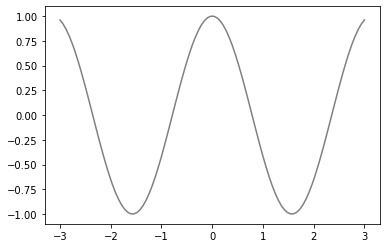

In [ ]:



y = lambda x: np.cos(x)**2-np.sin(x)**2

fig = plt.subplots()

x = np.linspace(-3, 3,100)

plt.plot(x, y(x), "grey")

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y= np.cos(x)**2-np.sin(x)**2, name='$$f(x)=x^2$$'))

fig.show()

In [ ]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))  #составляете обучающий набор из 1024 пар (x_1, x_2)
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length) #хранения случайных значений в интервале от 00 до 2π. 
train_data[:, 1] = torch.cos((train_data[:, 0]))**2-np.sin((train_data[:, 0]))**2 #вычисляем второй столбец тензора как наша ф-ия первого столбца.
train_labels = torch.zeros(train_data_length) #тензор, заполненный нулями
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)] #создаем train_set как список кортежей, где каждая строка train_data и train_labels представлена в каждом кортеже, как ожидается загрузчиком данных PyTorch.

Провериим данные

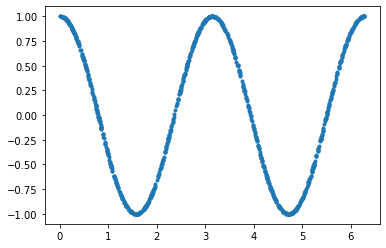

In [ ]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [ ]:
discriminator = Discriminator()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [ ]:
lr = 0.001
num_epochs = 1000
loss_function = nn.BCELoss()

In [ ]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        

Будем увеличивать epoch и смотреть что получается


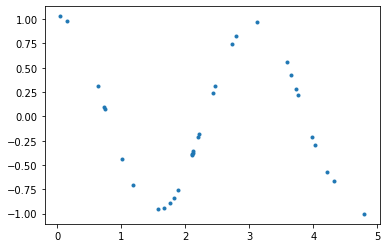

In [ ]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

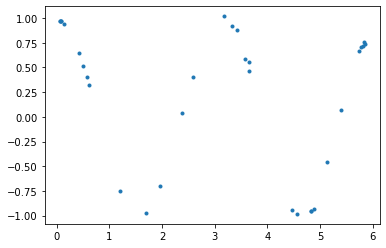

In [ ]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

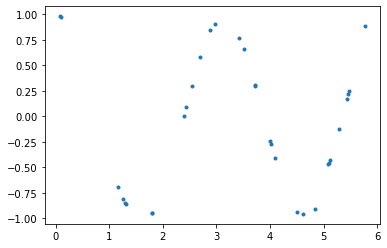

In [ ]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

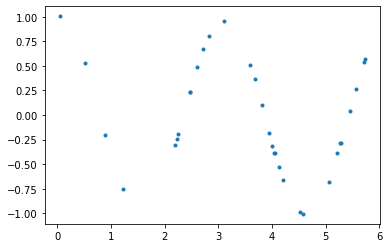

In [ ]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

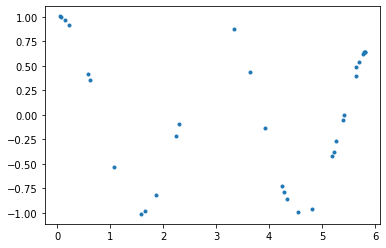

In [ ]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

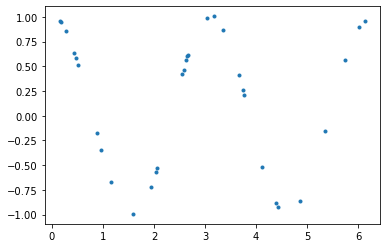

In [ ]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

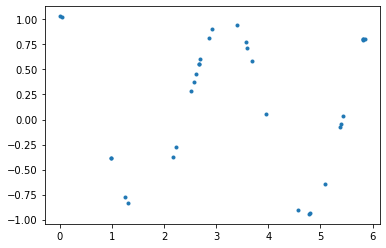

In [ ]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

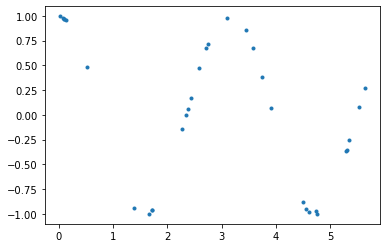

In [ ]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

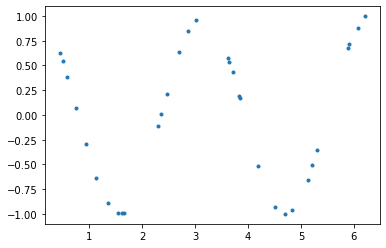

In [ ]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

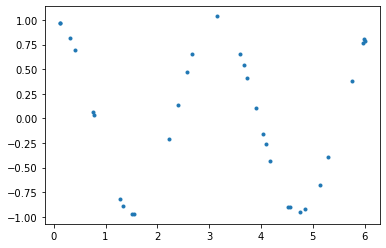

In [ ]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

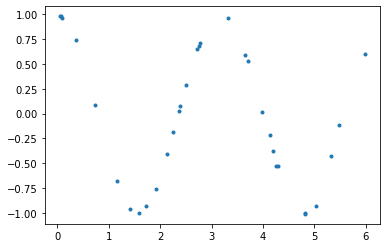

In [ ]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

Теперь рассмотрим пример чуть по сложнее и попробуем сгенирировать цирфы используя набор данных MNIST

In [ ]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [ ]:
torch.manual_seed(111)

In [ ]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)


In [ ]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

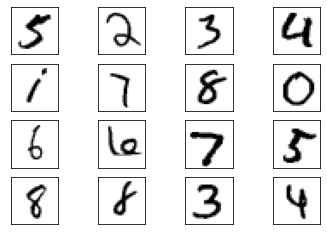

In [ ]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [ ]:
discriminator = Discriminator().to(device=device)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [ ]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()


In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

При 0 epoch получаем помехи

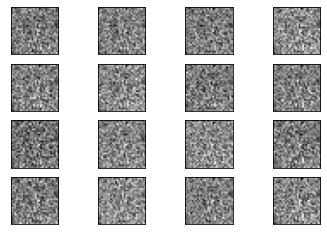

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

При 10 получаем уже лучшую картину

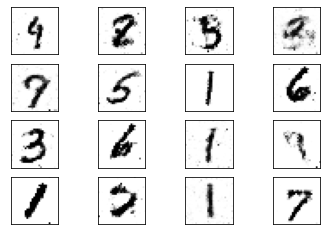

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:
from keras.optimizers import adam_v2


При 15 еще лучше

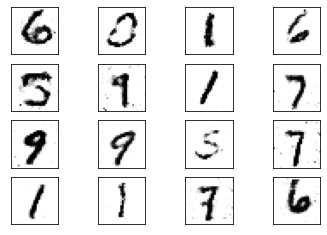

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:
from IPython.display import Image
Image(url='/drive/My Drive/fig_gan_mnist.gif')  
    
    

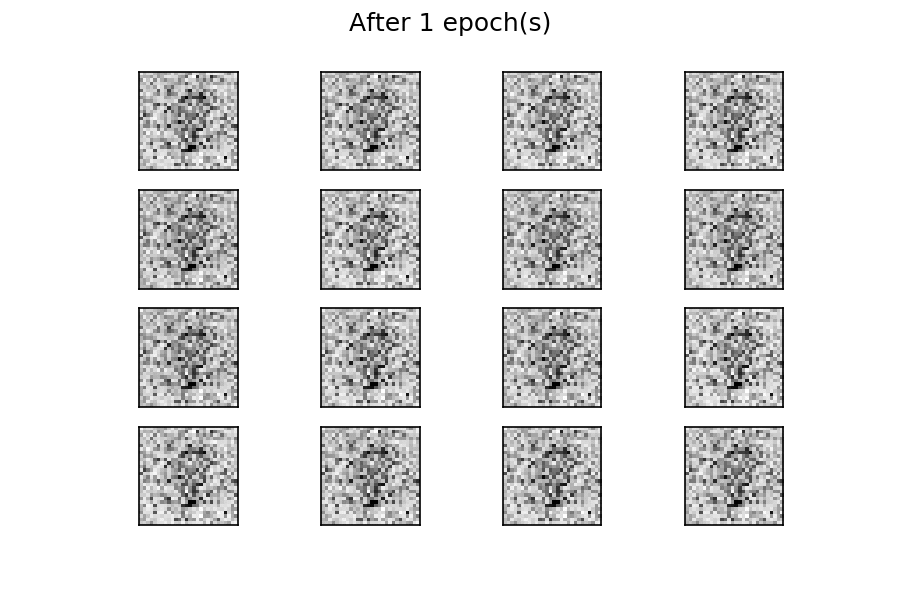

Теперь попробуем сгенирировать одежду

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


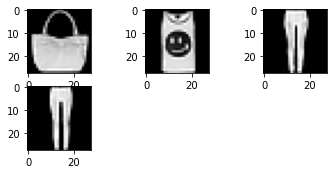

In [ ]:
from keras.datasets import fashion_mnist
from matplotlib import pyplot
# get training and testing vectors 
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

#printing the shapes of vectors 
print('X_train: ' + str(trainX.shape))
print('Y_train: ' + str(trainy.shape))
print('X_test:  '  + str(testX.shape))
print('Y_test:  '  + str(testy.shape))

#plotting 
for i in range(4):  
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(trainX[i+100], cmap=pyplot.get_cmap('gray'))
pyplot.show()



In [ ]:
from keras.datasets import fashion_mnist
# get training and testing vectors 
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()


In [ ]:
print('X_train: ' + str(trainX.shape))
print('Y_train: ' + str(trainy.shape))
print('X_test:  '  + str(testX.shape))
print('Y_test:  '  + str(testy.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [ ]:
train_set = torchvision.datasets.FashionMNIST(
    root=".", train=True, download=True, transform=transform
)

0it [00:00, ?it/s]

Extracting .\FashionMNIST\raw\train-images-idx3-ubyte.gz to .\FashionMNIST\raw


0it [00:00, ?it/s]

Extracting .\FashionMNIST\raw\train-labels-idx1-ubyte.gz to .\FashionMNIST\raw


0it [00:00, ?it/s]

Extracting .\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to .\FashionMNIST\raw


0it [00:00, ?it/s]

Extracting .\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to .\FashionMNIST\raw
Processing...
Done!


In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

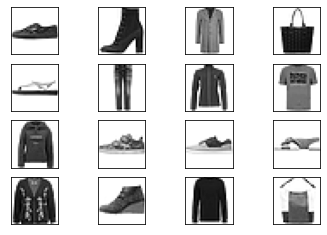

In [ ]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [ ]:
discriminator = Discriminator().to(device=device)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [ ]:
lr = 0.0001
num_epochs = 100
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

       

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

after 10 epochs

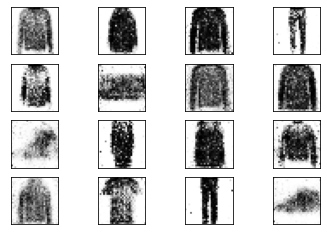

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

after 11 epochs

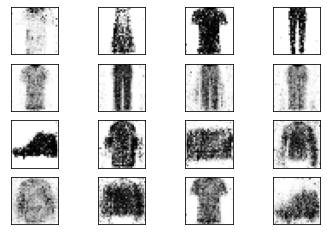

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

Сравним с исходными изображениями 

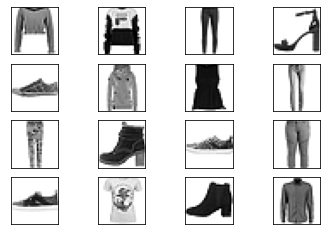

In [ ]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

Теперь замахнемся на что то более существенное и попробуем сгенирировать лица людей. Для этого воспользуемся базой данных лиц знаменитостей из Kaggle. 

100%|██████████| 665/665 [00:19<00:00, 33.45it/s] 


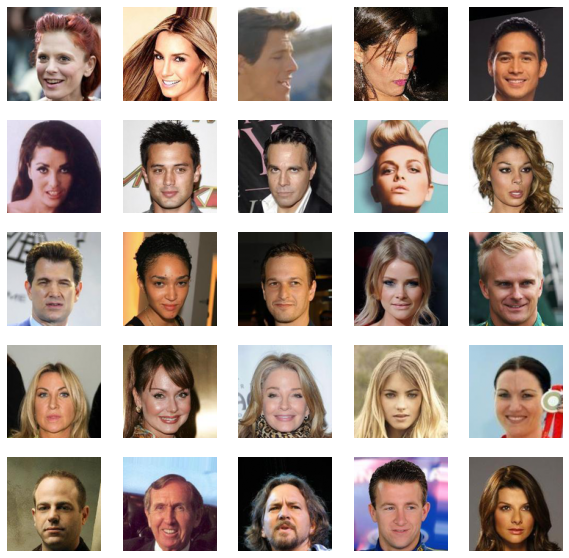

In [ ]:
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
PIC_DIR = './drive/My Drive/img_align_celeba/'  
IMAGES_COUNT = 10000
ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
WIDTH = 128
HEIGHT = 128
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)
images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic)) #Normalize the images
images = np.array(images) / 255
images.shape #print first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.optimizers import RMSprop,Adam

In [ ]:
LATENT_DIM = 32
CHANNELS = 3
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))
    
    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)
    
    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)
    
    generator = Model(gen_input, x)
    return generator

In [ ]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    
    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)
    
    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
    
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )
    
    return discriminator

In [ ]:
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model

from tensorflow.keras.optimizers import RMSprop

In [ ]:
generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False

gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')


import time
iters = 200
batch_size = 9

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
RES_DIR = './drive/My Drive/res5'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    
    gan.save_weights('/gan.h5')

    print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

    control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
    control_generated = generator.predict(control_vectors)
    for i in range(CONTROL_SIZE_SQRT ** 2):
      x_off = i % CONTROL_SIZE_SQRT
      y_off = i // CONTROL_SIZE_SQRT
      control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
    im = Image.fromarray(np.uint8(control_image * 255))
    im.save(FILE_PATH % (RES_DIR, images_saved))
    images_saved += 1

1/30: d_loss: 0.6935,  a_loss: 0.6932.  (180.5 sec)
2/30: d_loss: 0.5420,  a_loss: 0.5231.  (188.4 sec)
3/30: d_loss: 3.7477,  a_loss: 0.4256.  (172.7 sec)
4/30: d_loss: 0.9854,  a_loss: 0.6462.  (175.9 sec)
5/30: d_loss: 0.6931,  a_loss: 1.1006.  (172.7 sec)
6/30: d_loss: 0.5939,  a_loss: 1.4738.  (172.6 sec)
7/30: d_loss: 0.5695,  a_loss: 1.3596.  (172.0 sec)
8/30: d_loss: 0.5773,  a_loss: 1.5077.  (173.7 sec)
9/30: d_loss: 0.6751,  a_loss: 0.8598.  (173.8 sec)
10/30: d_loss: 0.7175,  a_loss: 0.6634.  (175.5 sec)
11/30: d_loss: 0.6605,  a_loss: 0.6394.  (180.8 sec)
12/30: d_loss: 0.6362,  a_loss: 0.6535.  (175.9 sec)
13/30: d_loss: 0.6102,  a_loss: 0.6807.  (175.0 sec)
14/30: d_loss: 0.6182,  a_loss: 0.9470.  (178.8 sec)
15/30: d_loss: 0.6123,  a_loss: 0.6511.  (174.9 sec)
16/30: d_loss: 0.6368,  a_loss: 0.7090.  (177.5 sec)
17/30: d_loss: 0.6494,  a_loss: 0.6113.  (174.3 sec)
18/30: d_loss: 0.6426,  a_loss: 1.0297.  (174.5 sec)
19/30: d_loss: 0.6528,  a_loss: 0.6693.  (173.3 sec)
20

Посмотрим графики обучения

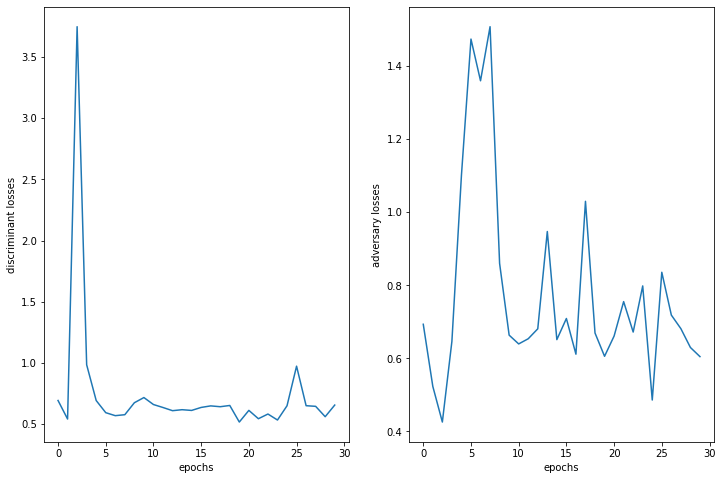

In [ ]:
from matplotlib import pyplot as plt
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()


import imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('/drive/My Drive/visual1.gif', images_to_gif)
shutil.rmtree(RES_DIR)

Получили что то такое

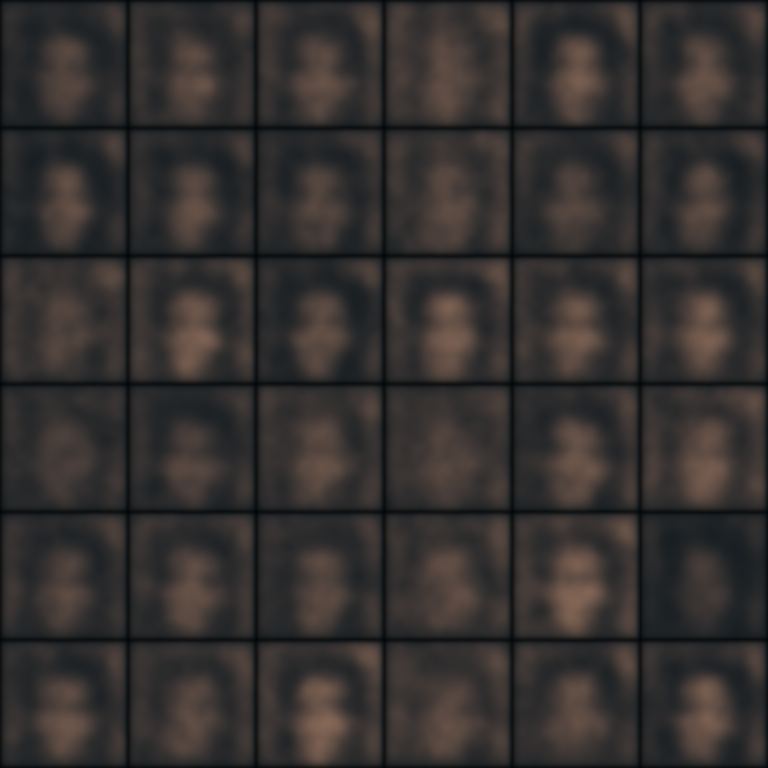

Да выглядиит не очень, но и время обучение было небольшим.

Увеличим количество циклов

In [ ]:
RES_DIR = './drive/My Drive/res5'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    
    gan.save_weights('./drive/My Drive/gan.h5')

    print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

    control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
    control_generated = generator.predict(control_vectors)
    for i in range(CONTROL_SIZE_SQRT ** 2):
      x_off = i % CONTROL_SIZE_SQRT
      y_off = i // CONTROL_SIZE_SQRT
      control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
    im = Image.fromarray(np.uint8(control_image * 255))
    im.save(FILE_PATH % (RES_DIR, images_saved))
    images_saved += 1

1/200: d_loss: 0.6853,  a_loss: 0.6928.  (234.3 sec)
2/200: d_loss: 0.5122,  a_loss: 0.5355.  (232.1 sec)
3/200: d_loss: 3.6092,  a_loss: 0.3892.  (228.5 sec)
4/200: d_loss: 1.0585,  a_loss: 0.6100.  (229.7 sec)
5/200: d_loss: 0.7179,  a_loss: 0.9508.  (224.3 sec)
6/200: d_loss: 0.6085,  a_loss: 1.3499.  (224.4 sec)
7/200: d_loss: 0.5890,  a_loss: 1.4835.  (233.2 sec)
8/200: d_loss: 0.6201,  a_loss: 1.1343.  (227.7 sec)
9/200: d_loss: 0.7146,  a_loss: 0.6934.  (261.1 sec)
10/200: d_loss: 0.6649,  a_loss: 0.6716.  (234.3 sec)
11/200: d_loss: 0.6435,  a_loss: 0.6615.  (235.8 sec)
12/200: d_loss: 0.6235,  a_loss: 0.6874.  (229.2 sec)
13/200: d_loss: 0.6301,  a_loss: 0.7031.  (232.8 sec)
14/200: d_loss: 0.6228,  a_loss: 0.7363.  (236.3 sec)
15/200: d_loss: 0.6130,  a_loss: 0.6558.  (232.3 sec)
16/200: d_loss: 0.6580,  a_loss: 0.8399.  (227.5 sec)
17/200: d_loss: 0.6620,  a_loss: 0.6329.  (233.5 sec)
18/200: d_loss: 0.6179,  a_loss: 0.6299.  (232.7 sec)
19/200: d_loss: 0.6510,  a_loss: 0.80

NameError: ignored

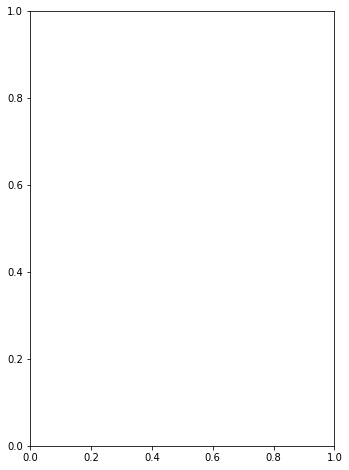

In [ ]:
from matplotlib import pyplot as plt
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()


import imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('/drive/My Drive/visual1.gif', images_to_gif)
shutil.rmtree(RES_DIR)